## Installing neccessary libraries

We'll employ several popular Python packages to fine-tune the Whisper model. We'll use datasets[audio] to download and prepare our training data, alongside transformers and accelerate to load and train our Whisper model. We'll also require the soundfile package to pre-process audio files, evaluate and jiwer to assess the performance of our model, and tensorboard to log our metrics. Finally, we'll use gradio to build a flashy demo of our fine-tuned model.

In [ ]:
!pip install --upgrade pip
!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard

## Hugging face authentication

Hugging face authentication using token

In [ ]:
from huggingface_hub import login

# write your own secret key or token
login('your_token')

## Loading dataset

We'll use the Common Voice dataset at the time of writing (version 11). As for our language, we'll fine-tune our model on Hindi, an Indo-Aryan language spoken in northern, central, eastern, and western India.

In [ ]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_11_0", "hi", split="train+validation", trust_remote_code=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_11_0", "hi", split="test", trust_remote_code=True)

print(common_voice)

we only consider the input audio and transcribed text for fine-tuning, discarding the additional metadata information:

In [ ]:
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])

load the feature extractor from the pre-trained checkpoint to have ready for our audio data

## Feature extractor, tokenizer and processor

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")


The Whisper tokenizer is pre-trained on the transcriptions for the 96 pre-training languages. Consequently, it has an extensive byte-pair that is appropriate for almost all multilingual ASR applications. For Hindi, we can load the tokenizer and use it for fine-tuning without any further modifications. We simply have to specify the target language and the task. These arguments inform the tokenizer to prefix the language and task tokens to the start of encoded label sequences:

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Hindi", task="transcribe")


We can verify that the tokenizer correctly encodes Hindi characters by encoding and decoding the first sample of the Common Voice dataset. When encoding the transcriptions, the tokenizer appends 'special tokens' to the start and end of the sequence, including the start/end of transcript tokens, the language token and the task tokens (as specified by the arguments in the previous step). When decoding the label ids, we have the option of 'skipping' these special tokens, allowing us to return a string in the original input form:

In [ ]:
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

To simplify using the feature extractor and tokenizer, we can wrap both into a single WhisperProcessor class. This processor object inherits from the WhisperFeatureExtractor and WhisperProcessor and can be used on the audio inputs and model predictions as required. In doing so, we only need to keep track of two objects during training: the processor and the model:

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Hindi", task="transcribe")

Let's print the first example of the Common Voice dataset to see what form the data is in:

In [ ]:
print(common_voice["train"][0])

## Downsampling

we need to match the sampling rate of our audio to that of the Whisper model (16kHz). Since our input audio is sampled at 48kHz, we need to downsample it to 16kHz before passing it to the Whisper feature extractor.

In [ ]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

Re-loading the first audio sample in the Common Voice dataset will resample it to the desired sampling rate:

In [ ]:
print(common_voice["train"][0])

## Prepare dataset

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch


In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=4)

## Training and Evaluation

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [ ]:
model.generation_config.language = "hindi"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

Define a Data Collator

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

Evaluation Metrics

In [ ]:
import evaluate

metric = evaluate.load("wer")


In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


Define the Training Arguments

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-hindi-total",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=5000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

We can forward the training arguments to the 🤗 Trainer along with our model, dataset, data collator and compute_metrics function:

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)


Training

In [ ]:
trainer.train()

Our best WER is 32.0% after 4000 training steps. For reference, the pre-trained Whisper small model achieves a WER of 63.5%, meaning we achieve an improvement of 31.5% absolute through fine-tuning. Not bad for just 8h of training data!

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset": "Common Voice 11.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: hi, split: test",
    "language": "hi",
    "model_name": "Whisper Small Hi - Atharva Darvekar",  # a 'pretty' name for your model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}

The training results can now be uploaded to the Hub. To do so, execute the push_to_hub command:

In [ ]:
trainer.push_to_hub(**kwargs)

In [ ]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor

model = WhisperForConditionalGeneration.from_pretrained("Athrensis/whisper-small-hindi-total")
processor = WhisperProcessor.from_pretrained("Athrensis/whisper-small-hindi-total")

## WER graph

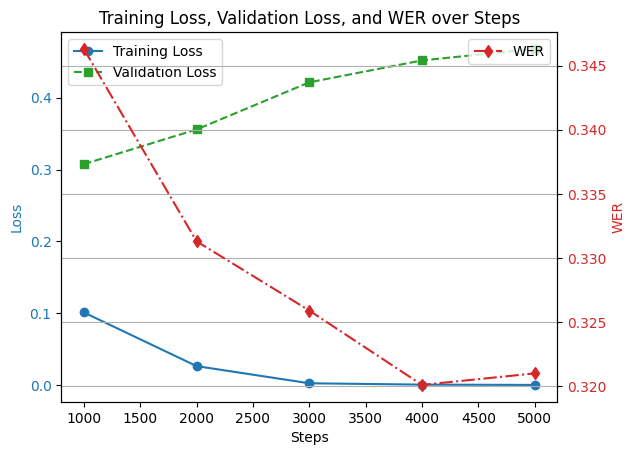

In [1]:
import matplotlib.pyplot as plt

# Data
steps = [1000, 2000, 3000, 4000, 5000]
training_loss = [0.1011, 0.0264, 0.0025, 0.0006, 0.0002]
validation_loss = [0.3075, 0.3558, 0.4214, 0.4519, 0.4679]
wer = [0.3463, 0.3313, 0.3259, 0.3201, 0.3210]

# Create plot
fig, ax1 = plt.subplots()

# Plot Training Loss and Validation Loss
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(steps, training_loss, marker='o', linestyle='-', color='tab:blue', label='Training Loss')
ax1.plot(steps, validation_loss, marker='s', linestyle='--', color='tab:green', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for WER
ax2 = ax1.twinx()
ax2.set_ylabel('WER', color='tab:red')
ax2.plot(steps, wer, marker='d', linestyle='-.', color='tab:red', label='WER')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Title and Grid
plt.title('Training Loss, Validation Loss, and WER over Steps')
plt.grid()

# Show plot
plt.show()